In [ ]:
# implementing our language model with a new architecture similar to Wavenet (2016) from DeepMind 
# https://arxiv.org/pdf/1609.03499 ---> link to the paper

In [19]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [21]:
# build the vocabulary of characters and mappings to and from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [22]:
# shuffle the words
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

In [3651]:
# build the dataset

block_size = 8  # context length

def build_dataset(words):
    X, Y = [], []  # X is the array of the input characters, Y is the output for those input characters
    
    for w in words:
        
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', ch)
            context = context[1:] + [ix]  # crop and append for next character's context
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [3646]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [3677]:
# almost the same as the layers from part 3
# -----------------------------------------------------------------------------------------------------------------------
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5  # kaiming init
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, x):  # __call__ allows an instance of a class to be called and used as a function by defining the function body
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
        
# -----------------------------------------------------------------------------------------------------------------------
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True  # this is for if we are training or using it on our dev set for evaluation or testing
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)  # this is like bngain
        self.beta = torch.zeros(dim)  # like bnbias
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)  # batch mean
            xvar = x.var(dim, keepdim=True)  # batch variance
        else:  # during inference, we are using the running mean and running variance
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------------------------------
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

# -----------------------------------------------------------------------------------------------------------------------
class FlattenConsecutive:  # concatenate the vectors

    def __init__(self, n):  # number of consecutive elements we want in a pair
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape  # shape of our input tensor, i.e. the output of the embedding layer
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)  # this will remove any dimension which is 1, i.e. unecessary. although here we specify we only want that to happen for the 2nd(i.e. index 1) dimension in our shape
        self.out = x
        return self.out

    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------------------------------
class Sequential:  # passes an input through all the layers

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [3678]:
torch.manual_seed(42);  # seed rng for reproducibility

In [3686]:
n_embd = 24  # dimensionality of the character embedding vectors
n_hidden = 128  # number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd), 
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameters init
with torch.no_grad():
    layers[-1].weight *= 0.1  # make last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # number of parameters in total

for p in parameters:
    p.requires_grad = True

76579


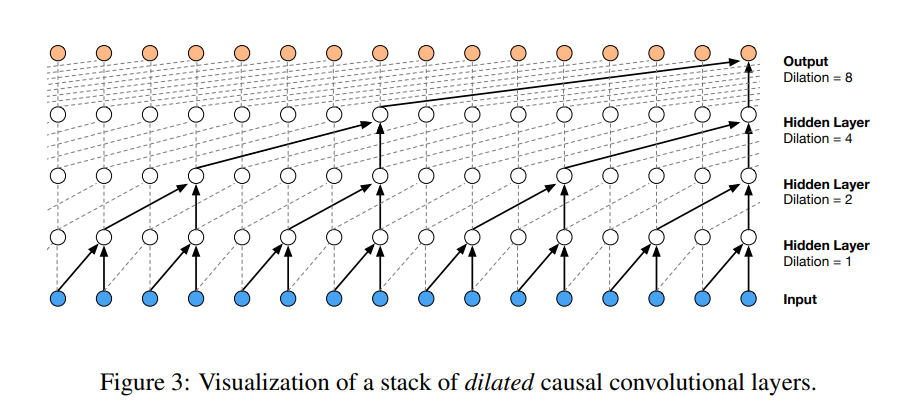

In [3689]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


In [3690]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

    # forward pass
    logits = model(Xb)  # we only need to pass the input data now
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # if i >= 1000:
    #break 

      0/ 200000: 3.3257
  10000/ 200000: 1.9580
  20000/ 200000: 1.9921
  30000/ 200000: 1.9754
  40000/ 200000: 2.3791
  50000/ 200000: 1.7930
  60000/ 200000: 1.8529
  70000/ 200000: 1.9964
  80000/ 200000: 1.7621
  90000/ 200000: 1.5067
 100000/ 200000: 1.9067
 110000/ 200000: 1.8767
 120000/ 200000: 1.8947
 130000/ 200000: 1.9009
 140000/ 200000: 1.5786
 150000/ 200000: 1.8566
 160000/ 200000: 1.5766
 170000/ 200000: 1.5446
 180000/ 200000: 1.5820
 190000/ 200000: 1.9717


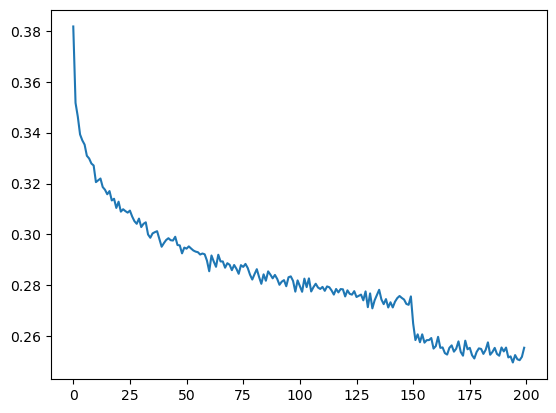

In [3691]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))  # better way to plot loss

In [3692]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [3693]:
# evaluate the loss
#this decorator disables gradient tracking
@torch.no_grad()  # pytorch will not keep track of gradients of tensors here, as they are not needed. To improve efficiency
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    logits = model(x)    
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7665892839431763
val 1.9984210729599


In [2976]:
# loss current:
# train 2.058394432067871
# val 2.1044557094573975

In [3703]:
# sample from the model

for _ in range(20):
    
    out = []
    context = [0] * block_size  # initialize with all '...'
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))  # decode and print generated word

arianny.
khayi.
alaysia.
aandryanus.
anahun.
aubriana.
salahra.
eloisen.
zamarison.
avinaya.
adalynns.
adalynn.
yailee.
dmarris.
jentrell.
skep.
lalana.
temily.
jakhi.
maheani.


In [58]:
# ------------------------ Notes and stuff ------------------------ #

In [41]:
torch.arange(10).view(-1, 5)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

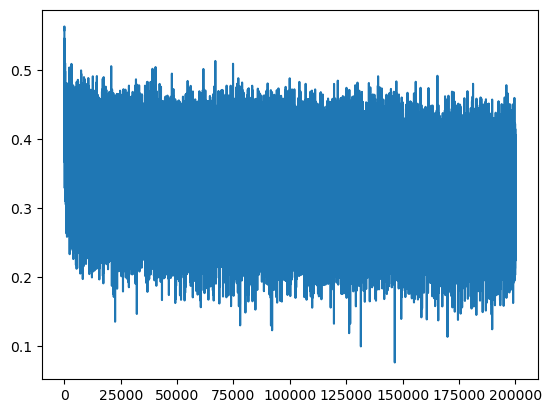

In [38]:
plt.plot(lossi)  # older and uglier way to plot loss

In [3656]:
ix = torch.randint(0, Xtr.shape[0], (4,))  # let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0, 12,  1, 14,  4,  5],
        [ 0,  0,  0,  0,  0,  7, 18,  1],
        [ 0,  0,  0,  0,  0,  0,  7, 18],
        [ 0,  0,  0,  5, 12, 12,  9, 19]])

In [3657]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [3606]:
model.layers[0].out.shape  # output of the embedding layer

torch.Size([4, 8, 10])

In [3607]:
model.layers[1].out.shape  # output of the flatten layer

torch.Size([4, 80])

In [3608]:
model.layers[2].out.shape  # output of the linear layer

torch.Size([4, 200])

In [3611]:
# just a random example
(torch.randn(4, 5, 2, 80) @ torch.randn(80, 200) + torch.randn(200)).shape  # you can matrix multiply even higher dimension tensors

torch.Size([4, 5, 2, 200])

In [ ]:
# (1 2) (3 4) (5 6) (7 8)
# so instead of 80 we just want 20 at a time

In [3613]:
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape  # 4 groups of 2 characters each, so 20 in each. the first 4 is just because we chose 4 examples here

torch.Size([4, 4, 200])

In [3614]:
list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [3624]:
e = torch.randn(4, 8, 10)  # goal: want this to be (4, 4, 20) where consecutive 10-d vectors get concatenated
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)  # concatenate the even and odd to get those pairings, along dim 2
explicit.shape

torch.Size([4, 4, 20])

In [3627]:
(e.view(4, 4, 20) == explicit).all()  # True

tensor(True)

In [3664]:
e = torch.randn(32, 4, 68)
emean = e.mean(0, keepdim=True)  # 1, 4, 68
evar = e.var(0, keepdim=True)  # 1, 4, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5)  # 32, 4, 68
ehat.shape
# torch.Size([32, 4, 68])

emean = e.mean((0, 1), keepdim=True)  # 1, 1, 68
evar = e.var((0, 1), keepdim=True)  # 1, 1, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5)  # 32, 4, 68
ehat.shape

torch.Size([1, 1, 68])


torch.Size([32, 4, 68])